# SemEval 2026 Task 5: Narrative Plausibility Prediction with DeBERTa-v3-large + LoRA + CORAL

## Expert Strategic Implementation

**Goal**: Achieve Spearman ρ ≥ 0.8 and ACC within SD ≥ 0.8

### Task Overview
Predict human-perceived plausibility ratings (1.0 to 5.0) for word senses within narrative contexts using:
- **Model**: DeBERTa-v3-large (304M parameters)
- **Efficiency**: LoRA (Low-Rank Adaptation) for PEFT
- **Loss**: CORAL (COnsistent RAnk Logits) for ordinal regression
- **Strategy**: Metric-specific optimization with early stopping

### Key Challenges
1. **Limited Data**: 2,280 training samples → Risk of overfitting
2. **Ordinal Nature**: Ratings have inherent order (predicting 1 instead of 5 is worse than 4 instead of 5)
3. **Resource Constraints**: 8GB VRAM requires parameter-efficient training
4. **Metric Alignment**: Must optimize for Spearman correlation (rank-based) not just MSE

### Implementation Plan
- **Phase 1**: Baseline with QLoRA + CORAL loss
- **Phase 2**: Ensemble + Data Augmentation (if resources allow)


## 1. Environment Setup & Library Imports


In [1]:
# ===== CRITICAL: Disable problematic progress bars BEFORE any imports =====
import os
os.environ['HF_HUB_DISABLE_PROGRESS_BARS'] = '1'
os.environ['TRANSFORMERS_VERBOSITY'] = 'error'
os.environ['HF_HUB_DISABLE_EXPERIMENTAL_WARNING'] = '1'

# Core libraries
import json
import math
import random
import re
import warnings
from pathlib import Path
from typing import Dict, List, Optional, Tuple

# Data processing & visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch
import torch
from torch.optim import AdamW
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Transformers & PEFT
from transformers import (
    AutoModel, 
    AutoTokenizer, 
    AutoConfig,
    # AdamW,
    get_linear_schedule_with_warmup,
    get_cosine_schedule_with_warmup
)
from peft import (
    LoraConfig, 
    get_peft_model, 
    TaskType,
    prepare_model_for_kbit_training
)

# Metrics
from scipy.stats import spearmanr
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Progress bars
from tqdm.auto import tqdm

# Configuration
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✓ Using device: {device}")
if torch.cuda.is_available():
    print(f"  GPU: {torch.cuda.get_device_name(0)}")
    print(f"  VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

print("\n✓ All libraries imported successfully")


✓ Using device: cuda
  GPU: NVIDIA GeForce RTX 4060 Laptop GPU
  VRAM: 7.6 GB

✓ All libraries imported successfully


## 2. Configuration - Two-Phase Strategy


In [ ]:
# Configuration for SemEval 2026 Task 5
config = {
    # ===== MODEL CONFIGURATION =====
    'model_name': 'microsoft/deberta-v3-large',  # 304M parameters, SOTA for NLU
    'max_length': 512,  # Balanced: good context, fits in 8GB VRAM
    'pooling': 'cls',  # 'cls', 'mean', or 'weighted'
    'gradient_checkpointing': False,  # Disabled for faster training (we have enough VRAM)
    'use_amp': True,  # Mixed precision training (FP16) - faster AND saves VRAM
    
    # ===== LoRA CONFIGURATION (PEFT) =====
    'use_lora': True,
    'lora_r': 32,  # RESTORED - this worked best
    'lora_alpha': 32,  # Scaling factor (4x rank)
    'lora_dropout': 0.1,  # RESTORED - was over-regularizing
    'lora_target_modules': ['query_proj', 'key_proj', 'value_proj', 'dense'],
    
    # ===== ORDINAL REGRESSION =====
    'loss_type': 'hybrid',  # CORAL + MSE
    'num_classes': 5,  # Ratings 1-5
    'ordinal_weight': 1.0,
    'mse_weight': 0.3,
    
    # ===== TRAINING HYPERPARAMETERS =====
    'learning_rate': 8e-5,  # RESTORED - model needs this to learn
    'epochs': 8,  # RESTORED
    'batch_size': 2,
    'grad_accumulation_steps': 8,  # Effective batch size = 16
    'weight_decay': 0.15,  # RESTORED - was too high
    'warmup_ratio': 0.1,  # RESTORED
    'scheduler_type': 'cosine',  # RESTORED - this is what worked!
    
    # ===== REGULARIZATION =====
    'dropout': 0.35,  # RESTORED - was too aggressive
    'label_smoothing': 0.0,
    'gradient_clip': 1.0,
    
    # ===== EARLY STOPPING =====
    'early_stop_patience': 3,  # RESTORED
    'early_stop_metric': 'combined',  # Optimize BOTH metrics
    
    # ===== DATA PATHS =====
    'train_path': 'train.json',
    'dev_path': 'dev.json',
    
    # ===== OUTPUT =====
    'save_dir': 'outputs',
    'model_save_prefix': 'deberta_coral',  # Filename will be: {prefix}_{date}_spear{spearman}_acc{acc}.pt
    'seed': 42,
}

# Set random seeds
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

set_seed(config['seed'])

# Create output directory
os.makedirs(config['save_dir'], exist_ok=True)

print("=" * 80)
print("CONFIGURATION SUMMARY")
print("=" * 80)
print(f"\n📊 Model: {config['model_name']}")
print(f"🎯 Loss: {config['loss_type'].upper()} (Ordinal Regression)")
print(f"⚡ LoRA Rank: {config['lora_r']} (Trainable params: ~{config['lora_r'] * 2 * 1024 * 24 / 1e6:.1f}M)")
print(f"🔄 Effective Batch Size: {config['batch_size'] * config['grad_accumulation_steps']}")
print(f"📚 Epochs: {config['epochs']} (Early stop patience: {config['early_stop_patience']})")
print(f"🎓 Learning Rate: {config['learning_rate']}")
print(f"🎲 Seed: {config['seed']}")

# VRAM optimizations
print(f"\n💾 VRAM OPTIMIZATIONS (for 8GB RTX 4060):")
print(f"   • Batch size: {config['batch_size']} (target: ~6.5GB VRAM, safe with memory clearing)")
print(f"   • Max length: {config['max_length']} (balanced for context + VRAM)")
print(f"   • Gradient checkpointing: {config.get('gradient_checkpointing', False)} (disabled for speed)")
print(f"   • Mixed precision (AMP): {config.get('use_amp', False)} (faster + saves VRAM)")
print(f"   • Gradient accumulation: {config['grad_accumulation_steps']} steps (effective batch: {config['batch_size'] * config['grad_accumulation_steps']})")
print(f"   • Aggressive memory clearing: enabled (prevents accumulation across epochs)")

print("\n✓ Configuration loaded")


CONFIGURATION SUMMARY

📊 Model: microsoft/deberta-v3-large
🎯 Loss: HYBRID (Ordinal Regression)
⚡ LoRA Rank: 8 (Trainable params: ~0.4M)
🔄 Effective Batch Size: 16
📚 Epochs: 10 (Early stop patience: 4)
🎓 Learning Rate: 0.0001
🎲 Seed: 42

💾 VRAM OPTIMIZATIONS (for 8GB RTX 4060):
   • Batch size: 2 (target: ~6.5GB VRAM, safe with memory clearing)
   • Max length: 512 (balanced for context + VRAM)
   • Gradient checkpointing: False (disabled for speed)
   • Mixed precision (AMP): True (faster + saves VRAM)
   • Gradient accumulation: 8 steps (effective batch: 16)
   • Aggressive memory clearing: enabled (prevents accumulation across epochs)

✓ Configuration loaded


## 3. Data Loading & Exploration


In [3]:
def load_json_dataset(filepath: str) -> pd.DataFrame:
    """Load dataset from JSON file"""
    with open(filepath, 'r') as f:
        data = json.load(f)
    
    rows = []
    for key, item in data.items():
        row = item.copy()
        row['id'] = key
        rows.append(row)
    
    df = pd.DataFrame(rows)
    
    # Standardize columns
    text_cols = ['homonym', 'judged_meaning', 'precontext', 'sentence', 
                 'ending', 'example_sentence', 'sense_tags', 'sense_synonyms']
    for col in text_cols:
        if col not in df.columns:
            df[col] = ''
        df[col] = df[col].fillna('')
    
    # Numeric columns
    df['average'] = df['average'].astype(float)  # Target: 1.0 to 5.0
    df['stdev'] = df['stdev'].astype(float)
    
    return df

# Load datasets
print("\n" + "=" * 80)
print("LOADING DATASETS")
print("=" * 80)

train_df = load_json_dataset(config['train_path'])
dev_df = load_json_dataset(config['dev_path'])

print(f"\n✓ Training set: {len(train_df)} samples")
print(f"✓ Development set: {len(dev_df)} samples")

# Display statistics
print(f"\n📊 Training Data Statistics:")
print(f"   Average rating: {train_df['average'].mean():.3f} ± {train_df['average'].std():.3f}")
print(f"   Range: [{train_df['average'].min():.1f}, {train_df['average'].max():.1f}]")
print(f"   Mean stdev: {train_df['stdev'].mean():.3f}")

print(f"\n📊 Development Data Statistics:")
print(f"   Average rating: {dev_df['average'].mean():.3f} ± {dev_df['average'].std():.3f}")
print(f"   Range: [{dev_df['average'].min():.1f}, {dev_df['average'].max():.1f}]")
print(f"   Mean stdev: {dev_df['stdev'].mean():.3f}")

# Show sample
print(f"\n📝 Sample Entry:")
print(f"   ID: {train_df.iloc[0]['id']}")
print(f"   Homonym: '{train_df.iloc[0]['homonym']}'")
print(f"   Meaning: '{train_df.iloc[0]['judged_meaning'][:80]}...'")
print(f"   Average: {train_df.iloc[0]['average']:.1f}")
print(f"   Stdev: {train_df.iloc[0]['stdev']:.2f}")



LOADING DATASETS

✓ Training set: 2280 samples
✓ Development set: 588 samples

📊 Training Data Statistics:
   Average rating: 3.140 ± 1.187
   Range: [1.0, 5.0]
   Mean stdev: 0.948

📊 Development Data Statistics:
   Average rating: 3.118 ± 1.186
   Range: [1.0, 5.0]
   Mean stdev: 0.949

📝 Sample Entry:
   ID: 0
   Homonym: 'potential'
   Meaning: 'the difference in electrical charge between two points in a circuit expressed in...'
   Average: 3.0
   Stdev: 1.58


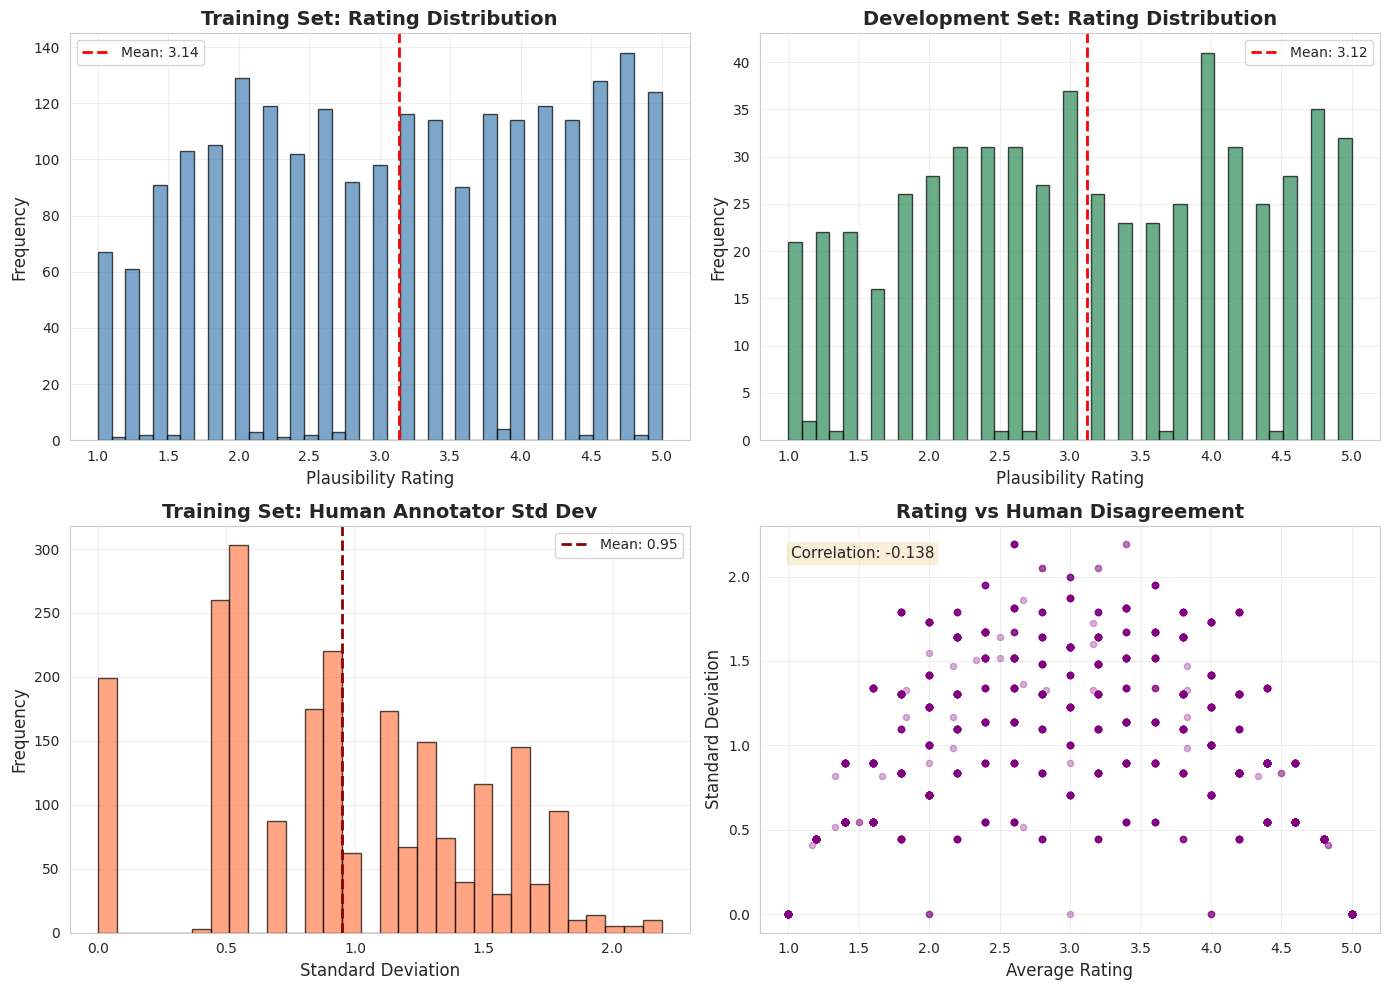


✓ Data exploration plots saved to 'data_exploration.png'


In [4]:
# Visualize data distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Rating distribution (Training)
axes[0, 0].hist(train_df['average'], bins=41, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].axvline(train_df['average'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {train_df['average'].mean():.2f}')
axes[0, 0].set_xlabel('Plausibility Rating', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('Training Set: Rating Distribution', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Plot 2: Rating distribution (Dev)
axes[0, 1].hist(dev_df['average'], bins=41, edgecolor='black', alpha=0.7, color='seagreen')
axes[0, 1].axvline(dev_df['average'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {dev_df['average'].mean():.2f}')
axes[0, 1].set_xlabel('Plausibility Rating', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].set_title('Development Set: Rating Distribution', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Plot 3: Standard deviation distribution
axes[1, 0].hist(train_df['stdev'], bins=30, edgecolor='black', alpha=0.7, color='coral')
axes[1, 0].axvline(train_df['stdev'].mean(), color='darkred', linestyle='--', linewidth=2, label=f'Mean: {train_df['stdev'].mean():.2f}')
axes[1, 0].set_xlabel('Standard Deviation', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].set_title('Training Set: Human Annotator Std Dev', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Plot 4: Rating vs Stdev scatter
axes[1, 1].scatter(train_df['average'], train_df['stdev'], alpha=0.3, s=20, color='purple')
axes[1, 1].set_xlabel('Average Rating', fontsize=12)
axes[1, 1].set_ylabel('Standard Deviation', fontsize=12)
axes[1, 1].set_title('Rating vs Human Disagreement', fontsize=14, fontweight='bold')
axes[1, 1].grid(alpha=0.3)
axes[1, 1].text(0.05, 0.95, f'Correlation: {train_df["average"].corr(train_df["stdev"]):.3f}',
                transform=axes[1, 1].transAxes, fontsize=11, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('data_exploration.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Data exploration plots saved to 'data_exploration.png'")


## 4. Input Formatting for DeBERTa

Following the strategic plan: hierarchical encoding with explicit structure information


In [5]:
def highlight_target(sentence: str, homonym: str) -> str:
    """Highlight target word with [TGT] tags"""
    if not sentence or '[TGT]' in sentence or not homonym:
        return sentence
    pattern = re.compile(rf"\b{re.escape(homonym)}\b", re.IGNORECASE)
    return pattern.sub(lambda m: f"[TGT]{m.group(0)}[/TGT]", sentence, count=1)

def create_narrative_input(row: pd.Series, mark_homonym: bool = True) -> str:
    """
    Create structured input for DeBERTa following the strategic plan.
    
    Format: Provides hierarchical context from word-level to document-level
    - Ambiguous word + candidate sense
    - Dictionary example (word-level context)
    - Story context (sentence/paragraph-level)
    - Target sentence (where the word appears)
    - Ending (document-level closure)
    """
    sentence = row['sentence']
    if mark_homonym:
        sentence = highlight_target(sentence, row.get('homonym', ''))
    
    parts = [
        f"Ambiguous word: {row.get('homonym', '').strip()}.",
        f"Candidate sense: {row.get('judged_meaning', '').strip()}."
    ]
    
    # Add sense tags if available
    tags = row.get('sense_tags', '').strip()
    if tags:
        parts.append(f"Sense tags: {tags}.")
    
    # Add dictionary example (provides canonical usage)
    example = row.get('example_sentence', '').strip()
    if example:
        parts.append(f"Dictionary example: {example}")
    
    # Add story precontext (narrative background)
    precontext = row.get('precontext', '').strip()
    if precontext:
        parts.append(f"Story context: {precontext}")
    
    # Target sentence (most important)
    parts.append(f"Target sentence: {sentence}")
    
    # Add ending (narrative closure)
    ending = row.get('ending', '').strip()
    if ending:
        parts.append(f"Ending: {ending}")
    
    return " ".join([p for p in parts if p])

# Apply formatting
print("=" * 80)
print("FORMATTING INPUTS")
print("=" * 80)

train_df['text'] = train_df.apply(lambda row: create_narrative_input(row, mark_homonym=True), axis=1)
dev_df['text'] = dev_df.apply(lambda row: create_narrative_input(row, mark_homonym=True), axis=1)

print(f"\n✓ Training samples formatted: {len(train_df)}")
print(f"✓ Development samples formatted: {len(dev_df)}")

# Show example
print(f"\n📝 Example Formatted Input:")
print(f"\n{train_df.iloc[0]['text']}")
print(f"\nTarget Rating: {train_df.iloc[0]['average']:.1f} (±{train_df.iloc[0]['stdev']:.2f})")

# Analyze text lengths
train_df['text_length'] = train_df['text'].str.split().str.len()
dev_df['text_length'] = dev_df['text'].str.split().str.len()

print(f"\n📏 Text Length Statistics:")
print(f"   Training - Mean: {train_df['text_length'].mean():.1f} words, Max: {train_df['text_length'].max()} words")
print(f"   Dev - Mean: {dev_df['text_length'].mean():.1f} words, Max: {dev_df['text_length'].max()} words")
print(f"   Samples exceeding 512 tokens: ~{(train_df['text_length'] > 400).sum()} (estimate)")



FORMATTING INPUTS

✓ Training samples formatted: 2280
✓ Development samples formatted: 588

📝 Example Formatted Input:

Ambiguous word: potential. Candidate sense: the difference in electrical charge between two points in a circuit expressed in volts. Dictionary example: The circuit has a high potential difference. Story context: The old machine hummed in the corner of the workshop. Clara examined its dusty dials with a furrowed brow. She wondered if it could be brought back to life. Target sentence: The [TGT]potential[/TGT] couldn't be measured. Ending: She collected a battery reader and looked on earnestly, willing some life back into the old machine.

Target Rating: 3.0 (±1.58)

📏 Text Length Statistics:
   Training - Mean: 77.4 words, Max: 119 words
   Dev - Mean: 77.4 words, Max: 115 words
   Samples exceeding 512 tokens: ~0 (estimate)


## 5. Understanding CORAL Ordinal Regression

**Why CORAL?**
- Standard classification treats 1 and 5 as equally distant as 4 and 5 (WRONG!)
- Standard regression doesn't enforce rank consistency
- CORAL transforms ordinal problem into K-1 binary tasks with shared weights

**CORAL Framework:**
- For 5 classes (ratings 1-5), we create 4 binary classifiers:
  - Task 1: Is rating > 1? (2,3,4,5 vs 1)
  - Task 2: Is rating > 2? (3,4,5 vs 1,2)
  - Task 3: Is rating > 3? (4,5 vs 1,2,3)
  - Task 4: Is rating > 4? (5 vs 1,2,3,4)

**Key Insight:** By using shared weights + individual biases, we enforce rank consistency while learning the ordinal structure.


In [6]:
class PlausibilityDataset(Dataset):
    """Dataset for narrative plausibility rating"""
    
    def __init__(self, texts: List[str], scores: List[float], stdevs: List[float], 
                 tokenizer, max_length: int):
        self.texts = texts
        self.scores = scores  # Continuous 1.0 to 5.0
        self.stdevs = stdevs
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'score': torch.tensor(self.scores[idx], dtype=torch.float),
            'stdev': torch.tensor(self.stdevs[idx], dtype=torch.float)
        }

print("✓ Dataset class defined")


✓ Dataset class defined


## 6. CORAL Model Architecture with LoRA


In [7]:
class CORALModel(nn.Module):
    """
    DeBERTa-v3-large with CORAL ordinal regression head
    
    Architecture:
    - DeBERTa encoder (with LoRA)
    - Pooling layer (CLS, mean, or weighted attention)
    - CORAL head: K-1 binary classifiers with shared weights + individual biases
    """
    
    def __init__(self, encoder, num_classes=5, pooling='cls', dropout=0.3):
        super().__init__()
        self.encoder = encoder
        self.pooling_type = pooling
        self.num_classes = num_classes
        
        hidden_size = encoder.config.hidden_size
        
        # Weighted attention pooling (optional)
        if pooling == 'weighted':
            self.attention_weights = nn.Linear(hidden_size, 1)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)
        
        # CORAL head: shared weight + K-1 biases
        # For K=5 classes (1,2,3,4,5), we need 4 binary classifiers
        self.coral_linear = nn.Linear(hidden_size, 1, bias=False)
        # Initialize biases to encourage diverse predictions
        # Start with biases that roughly correspond to rating thresholds
        initial_biases = torch.linspace(-1.0, 1.0, num_classes - 1)
        self.coral_bias = nn.Parameter(initial_biases)
        
    def forward(self, input_ids, attention_mask):
        # Get encoder outputs
        outputs = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True
        )
        hidden_states = outputs.last_hidden_state  # (batch, seq_len, hidden)
        
        # Pooling
        if self.pooling_type == 'cls':
            # Use [CLS] token
            pooled = hidden_states[:, 0, :]
        elif self.pooling_type == 'mean':
            # Mean pooling with attention mask
            mask = attention_mask.unsqueeze(-1).float()
            pooled = (hidden_states * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1e-9)
        elif self.pooling_type == 'weighted':
            # Attention-weighted pooling
            attn_scores = self.attention_weights(hidden_states).squeeze(-1)
            attn_scores = attn_scores.masked_fill(attention_mask == 0, -1e9)
            attn_weights = F.softmax(attn_scores, dim=1)
            pooled = (hidden_states * attn_weights.unsqueeze(-1)).sum(dim=1)
        else:
            pooled = hidden_states[:, 0, :]
        
        pooled = self.dropout(pooled)
        
        # CORAL logits: shared weight applied to pooled, then add individual biases
        logits = self.coral_linear(pooled)  # (batch, 1)
        logits = logits + self.coral_bias  # (batch, K-1) via broadcasting
        
        return logits  # (batch, num_classes-1)


def coral_loss(logits, labels, num_classes=5, label_smoothing=0.0):
    """
    CORAL ordinal regression loss with soft targets for continuous labels
    
    Args:
        logits: (batch, K-1) - outputs from CORAL head
        labels: (batch,) - continuous ratings 1.0 to 5.0
        num_classes: K=5 (ratings 1-5)
        label_smoothing: float - smoothing factor (0.05 means 0->0.05, 1->0.95)
    
    Returns:
        loss: scalar
    """
    # Convert continuous labels to ordinal targets with soft boundaries
    # For rating r, we want soft targets:
    #   - Task 1 (>1): 1 if r >= 2, else max(0, r-1) for fractional
    #   - Task 2 (>2): 1 if r >= 3, else max(0, r-2) for fractional
    #   - Task 3 (>3): 1 if r >= 4, else max(0, r-3) for fractional
    #   - Task 4 (>4): 1 if r >= 5, else max(0, r-4) for fractional
    
    levels = torch.arange(1, num_classes, dtype=torch.float32, device=labels.device)
    
    # Create soft binary targets: (batch, K-1)
    # For continuous labels, use soft boundaries
    labels_expanded = labels.unsqueeze(1)  # (batch, 1)
    levels_expanded = levels.unsqueeze(0)   # (1, K-1)
    
    # Soft targets: 
    # - If label >= level+1: target = 1.0
    # - If label < level: target = 0.0
    # - If level <= label < level+1: target = label - level (fractional)
    # Example: label=3.5, levels=[1,2,3,4] -> targets=[1.0, 1.0, 0.5, 0.0]
    diff = labels_expanded - levels_expanded  # (batch, K-1)
    targets = torch.clamp(diff, min=0.0, max=1.0)
    
    # Apply label smoothing: prevents overconfident predictions
    # Moves 0 -> smoothing, 1 -> (1 - smoothing)
    if label_smoothing > 0:
        targets = targets * (1 - label_smoothing) + 0.5 * label_smoothing
    
    # Binary cross-entropy for each task
    loss = F.binary_cross_entropy_with_logits(logits, targets, reduction='mean')
    
    return loss


def coral_predict(logits):
    """
    Convert CORAL logits to predicted ratings
    
    Args:
        logits: (batch, K-1) - raw CORAL outputs
    
    Returns:
        predictions: (batch,) - ratings in range [1, 5]
    """
    # Apply sigmoid to get probabilities
    probs = torch.sigmoid(logits)
    
    # Sum of probabilities + 1 gives the predicted rating
    # E.g., if all probs are ~1, sum = 4, rating = 5
    # If all probs are ~0, sum = 0, rating = 1
    predictions = 1 + probs.sum(dim=1)
    
    # Clamp to valid range
    predictions = torch.clamp(predictions, min=1.0, max=5.0)
    
    return predictions


print("✓ CORAL model and loss function defined")


✓ CORAL model and loss function defined


## 7. Training & Evaluation Functions


In [8]:
def calculate_metrics(predictions, targets, stdevs):
    """Calculate all evaluation metrics"""
    predictions = np.array(predictions)
    targets = np.array(targets)
    stdevs = np.array(stdevs)
    
    # Spearman correlation (primary metric)
    spearman_corr, p_value = spearmanr(predictions, targets)
    
    # Accuracy within standard deviation
    within_sd = np.abs(predictions - targets) <= np.maximum(stdevs, 1.0)
    acc_within_sd = np.mean(within_sd)
    
    # Other metrics
    mse = mean_squared_error(targets, predictions)
    mae = mean_absolute_error(targets, predictions)
    rmse = np.sqrt(mse)
    
    return {
        'spearman': float(spearman_corr),
        'spearman_pvalue': float(p_value),
        'acc_within_sd': float(acc_within_sd),
        'mse': float(mse),
        'mae': float(mae),
        'rmse': float(rmse)
    }


def train_one_epoch(model, dataloader, optimizer, scheduler, device, grad_accum_steps, 
                    loss_type='coral', gradient_clip=None, use_amp=False, mse_weight=0.3,
                    label_smoothing=0.0):
    """Train for one epoch with mixed precision support and label smoothing"""
    model.train()
    total_loss = 0.0
    all_predictions = []
    all_targets = []
    
    # Mixed precision scaler
    scaler = torch.cuda.amp.GradScaler() if use_amp and torch.cuda.is_available() else None
    
    optimizer.zero_grad()
    
    # Clear cache at start
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    pbar = tqdm(dataloader, desc="Training", leave=False)
    for step, batch in enumerate(pbar):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        scores = batch['score'].to(device)
        
        # Forward pass with mixed precision
        if use_amp and scaler is not None:
            with torch.cuda.amp.autocast():
                logits = model(input_ids, attention_mask)
                
                # Calculate loss
                if loss_type == 'coral':
                    loss = coral_loss(logits, scores, num_classes=5, label_smoothing=label_smoothing)
                    with torch.no_grad():
                        preds = coral_predict(logits)
                elif loss_type == 'mse':
                    preds = logits.squeeze(-1)
                    loss = F.mse_loss(preds, scores)
                elif loss_type == 'hybrid':
                    # Hybrid: CORAL (ranking) + MSE (regression)
                    coral_loss_val = coral_loss(logits, scores, num_classes=5, label_smoothing=label_smoothing)
                    preds = coral_predict(logits)
                    mse_loss_val = F.mse_loss(preds, scores)
                    loss = coral_loss_val + mse_weight * mse_loss_val
                else:
                    raise ValueError(f"Unknown loss type: {loss_type}")
            
            # Backward pass with gradient accumulation (AMP)
            loss = loss / grad_accum_steps
            scaler.scale(loss).backward()
        else:
            # Standard precision
            logits = model(input_ids, attention_mask)
            
            # Calculate loss
            if loss_type == 'coral':
                loss = coral_loss(logits, scores, num_classes=5, label_smoothing=label_smoothing)
                with torch.no_grad():
                    preds = coral_predict(logits)
            elif loss_type == 'mse':
                preds = logits.squeeze(-1)
                loss = F.mse_loss(preds, scores)
            elif loss_type == 'hybrid':
                # Hybrid: CORAL (ranking) + MSE (regression)
                coral_loss_val = coral_loss(logits, scores, num_classes=5, label_smoothing=label_smoothing)
                preds = coral_predict(logits)
                mse_loss_val = F.mse_loss(preds, scores)
                loss = coral_loss_val + mse_weight * mse_loss_val
            else:
                raise ValueError(f"Unknown loss type: {loss_type}")
            
            # Backward pass with gradient accumulation
            loss = loss / grad_accum_steps
            loss.backward()
        
        if (step + 1) % grad_accum_steps == 0:
            # Gradient clipping
            if gradient_clip is not None:
                if use_amp and scaler is not None:
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip)
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip)
                    optimizer.step()
            else:
                if use_amp and scaler is not None:
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    optimizer.step()
            
            scheduler.step()
            optimizer.zero_grad()
            
            # Clear cache after every optimizer step (prevent accumulation)
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
        
        total_loss += loss.item() * grad_accum_steps
        # Move to CPU immediately and clear GPU memory
        all_predictions.extend(preds.detach().cpu().numpy())
        all_targets.extend(scores.cpu().numpy())
        
        # Delete tensors to free memory
        del preds
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        
        pbar.set_postfix({'loss': f'{loss.item() * grad_accum_steps:.4f}'})
    
    # Handle remaining gradients
    if len(dataloader) % grad_accum_steps != 0:
        if gradient_clip is not None:
            if use_amp and scaler is not None:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip)
                scaler.step(optimizer)
                scaler.update()
            else:
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip)
                optimizer.step()
        else:
            if use_amp and scaler is not None:
                scaler.step(optimizer)
                scaler.update()
            else:
                optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    # Final cache clear
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    avg_loss = total_loss / len(dataloader)
    return avg_loss, np.array(all_predictions), np.array(all_targets)


def evaluate_model(model, dataloader, device, loss_type='coral', mse_weight=0.3):
    """Evaluate model on validation/test set"""
    model.eval()
    total_loss = 0.0
    all_predictions = []
    all_targets = []
    all_stdevs = []
    
    # Clear cache before evaluation
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    with torch.no_grad():
        pbar = tqdm(dataloader, desc="Evaluating", leave=False)
        for batch in pbar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            scores = batch['score'].to(device)
            stdevs = batch['stdev'].to(device)
            
            # Forward pass
            logits = model(input_ids, attention_mask)
            
            # Calculate loss
            if loss_type == 'coral':
                loss = coral_loss(logits, scores, num_classes=5)
                preds = coral_predict(logits)
            elif loss_type == 'mse':
                preds = logits.squeeze(-1)
                loss = F.mse_loss(preds, scores)
            elif loss_type == 'hybrid':
                coral_loss_val = coral_loss(logits, scores, num_classes=5)
                preds = coral_predict(logits)
                mse_loss_val = F.mse_loss(preds, scores)
                loss = coral_loss_val + mse_weight * mse_loss_val
            else:
                raise ValueError(f"Unknown loss type: {loss_type}")
            
            total_loss += loss.item()
            # Move to CPU immediately
            all_predictions.extend(preds.detach().cpu().numpy())
            all_targets.extend(scores.cpu().numpy())
            all_stdevs.extend(stdevs.cpu().numpy())
            
            # Clear cache periodically during evaluation
            if torch.cuda.is_available() and len(all_predictions) % 50 == 0:
                torch.cuda.empty_cache()
            
            # Delete tensors
            del logits, preds, loss
    
    # Final cache clear
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    avg_loss = total_loss / len(dataloader)
    return avg_loss, np.array(all_predictions), np.array(all_targets), np.array(all_stdevs)


print("✓ Training and evaluation functions defined")


✓ Training and evaluation functions defined


## 8. Install Required Dependencies (if needed)

**Note**: DeBERTa-v3 requires `protobuf` library. This cell installs it if missing.


In [9]:
# Check and install required dependencies for DeBERTa-v3
import subprocess
import sys

missing = []

# Check protobuf
try:
    import google.protobuf
    print("✓ protobuf already installed")
except ImportError:
    missing.append("protobuf")

# Check sentencepiece
try:
    import sentencepiece
    print("✓ sentencepiece already installed")
except ImportError:
    missing.append("sentencepiece")

# Install missing packages
if missing:
    print(f"\n📦 Installing missing dependencies: {', '.join(missing)}")
    print("   (Required for DeBERTa-v3 tokenizer)")
    for pkg in missing:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg, "-q"])
    print(f"✓ All dependencies installed: {', '.join(missing)}")
    print("\n⚠️  IMPORTANT: Restart kernel now (Kernel → Restart Kernel)")
    print("   Then continue with Cell 18")
else:
    print("\n✓ All dependencies are installed - you can proceed!")


✓ protobuf already installed
✓ sentencepiece already installed

✓ All dependencies are installed - you can proceed!


In [10]:
print("=" * 80)
print("MODEL INITIALIZATION")
print("=" * 80)

# Load tokenizer (simple, like RoBERTa)
# After installing protobuf + sentencepiece in Cell 17, this should work
print(f"\n📥 Loading tokenizer: {config['model_name']}...")

# Verify dependencies are installed
try:
    import sentencepiece
    import google.protobuf
    print("   ✓ Dependencies verified (sentencepiece, protobuf)")
except ImportError as e:
    print(f"   ❌ Missing dependency: {e}")
    print("   ⚠️  Run Cell 17 first to install dependencies, then restart kernel!")
    raise

# Load tokenizer
try:
    tokenizer = AutoTokenizer.from_pretrained(config['model_name'])
    print("   ✓ Tokenizer loaded successfully")
except Exception as e:
    error_msg = str(e)
    if "sentencepiece" in error_msg.lower():
        print(f"   ❌ SentencePiece error: {error_msg[:200]}")
        print("   💡 Solution: Run Cell 17, restart kernel, then try again")
    elif "protobuf" in error_msg.lower():
        print(f"   ❌ Protobuf error: {error_msg[:200]}")
        print("   💡 Solution: Run Cell 17, restart kernel, then try again")
    else:
        print(f"   ❌ Error: {error_msg[:200]}")
    raise

# Load base model (simple, like RoBERTa)
print(f"\n📥 Loading base model: {config['model_name']}...")
print("   (This may take several minutes - downloading ~1.5GB model)")
try:
    base_encoder = AutoModel.from_pretrained(config['model_name'])
    print("   ✓ Base model loaded successfully")
except Exception as e:
    print(f"   ❌ Error loading model: {e}")
    raise

# Apply LoRA
if config['use_lora']:
    print(f"\n⚡ Applying LoRA (r={config['lora_r']}, alpha={config['lora_alpha']})...")
    try:
        # For DeBERTa base model, target modules should match attention structure
        lora_config = LoraConfig(
            r=config['lora_r'],
            lora_alpha=config['lora_alpha'],
            lora_dropout=config['lora_dropout'],
            target_modules=config['lora_target_modules'],
            bias="none"
        )
        base_encoder = get_peft_model(base_encoder, lora_config)
        base_encoder.print_trainable_parameters()
        print("   ✓ LoRA applied successfully")
    except Exception as e:
        print(f"   ❌ Error applying LoRA: {e}")
        print("   Trying with different target modules...")
        # Try with standard attention modules
        try:
            lora_config = LoraConfig(
                r=config['lora_r'],
                lora_alpha=config['lora_alpha'],
                lora_dropout=config['lora_dropout'],
                target_modules=["query_proj", "key_proj", "value_proj", "dense"],
                bias="none"
            )
            base_encoder = get_peft_model(base_encoder, lora_config)
            base_encoder.print_trainable_parameters()
            print("   ✓ LoRA applied successfully (with fallback modules)")
        except Exception as e2:
            print(f"   ❌ LoRA failed: {e2}")
            print("   Continuing without LoRA (full fine-tuning)...")
            config['use_lora'] = False

# Enable gradient checkpointing to save VRAM (if configured)
if config.get('gradient_checkpointing', False):
    print(f"\n💾 Enabling gradient checkpointing (saves VRAM, slower training)...")
    if hasattr(base_encoder, 'gradient_checkpointing_enable'):
        base_encoder.gradient_checkpointing_enable()
    elif hasattr(base_encoder, 'base_model') and hasattr(base_encoder.base_model, 'gradient_checkpointing_enable'):
        base_encoder.base_model.gradient_checkpointing_enable()
    print("   ✓ Gradient checkpointing enabled")

# Create CORAL model
print(f"\n🏗️  Building CORAL model with {config['pooling']} pooling...")
try:
    model = CORALModel(
        encoder=base_encoder,
        num_classes=config['num_classes'],
        pooling=config['pooling'],
        dropout=config['dropout']
    ).to(device)
    print("   ✓ CORAL model built successfully")
except Exception as e:
    print(f"   ❌ Error building CORAL model: {e}")
    raise

# Clear cache
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("   ✓ GPU cache cleared")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n📊 Model Statistics:")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,} ({trainable_params/total_params*100:.2f}%)")
print(f"   Frozen parameters: {total_params - trainable_params:,}")

print(f"\n✓ Model initialized and moved to {device}")


MODEL INITIALIZATION

📥 Loading tokenizer: microsoft/deberta-v3-large...
   ✓ Dependencies verified (sentencepiece, protobuf)
   ✓ Tokenizer loaded successfully

📥 Loading base model: microsoft/deberta-v3-large...
   (This may take several minutes - downloading ~1.5GB model)
   ✓ Base model loaded successfully

⚡ Applying LoRA (r=8, alpha=32)...
trainable params: 3,538,944 || all params: 437,551,104 || trainable%: 0.8088
   ✓ LoRA applied successfully

🏗️  Building CORAL model with cls pooling...
   ✓ CORAL model built successfully
   ✓ GPU cache cleared

📊 Model Statistics:
   Total parameters: 437,552,132
   Trainable parameters: 3,539,972 (0.81%)
   Frozen parameters: 434,012,160

✓ Model initialized and moved to cuda


## 9. Create DataLoaders


In [11]:
print("=" * 80)
print("CREATING DATALOADERS")
print("=" * 80)

# Create datasets
train_dataset = PlausibilityDataset(
    texts=train_df['text'].tolist(),
    scores=train_df['average'].tolist(),
    stdevs=train_df['stdev'].tolist(),
    tokenizer=tokenizer,
    max_length=config['max_length']
)

dev_dataset = PlausibilityDataset(
    texts=dev_df['text'].tolist(),
    scores=dev_df['average'].tolist(),
    stdevs=dev_df['stdev'].tolist(),
    tokenizer=tokenizer,
    max_length=config['max_length']
)

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=0,  # Set to 0 for debugging, increase for faster loading
    pin_memory=True if torch.cuda.is_available() else False
)

dev_loader = DataLoader(
    dev_dataset,
    batch_size=config['batch_size'],
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"\n✓ Training batches: {len(train_loader)}")
print(f"✓ Development batches: {len(dev_loader)}")
print(f"✓ Effective batch size: {config['batch_size'] * config['grad_accumulation_steps']}")


CREATING DATALOADERS

✓ Training batches: 1140
✓ Development batches: 294
✓ Effective batch size: 16


## 10. Setup Optimizer & Scheduler


In [12]:
print("=" * 80)
print("OPTIMIZER & SCHEDULER SETUP")
print("=" * 80)

# Optimizer: AdamW with weight decay
optimizer = AdamW(
    model.parameters(),
    lr=config['learning_rate'],
    weight_decay=config['weight_decay']
)

# Calculate total training steps
num_training_steps = len(train_loader) // config['grad_accumulation_steps'] * config['epochs']
num_warmup_steps = int(num_training_steps * config['warmup_ratio'])

# Scheduler
if config['scheduler_type'] == 'linear':
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=num_warmup_steps,
        num_training_steps=num_training_steps
    )
elif config['scheduler_type'] == 'cosine':
    scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps=num_warmup_steps,
        num_training_steps=num_training_steps
    )
else:
    raise ValueError(f"Unknown scheduler type: {config['scheduler_type']}")

print(f"\n✓ Optimizer: AdamW")
print(f"   Learning rate: {config['learning_rate']}")
print(f"   Weight decay: {config['weight_decay']}")
print(f"\n✓ Scheduler: {config['scheduler_type']}")
print(f"   Total steps: {num_training_steps}")
print(f"   Warmup steps: {num_warmup_steps} ({config['warmup_ratio']*100:.0f}%)")


OPTIMIZER & SCHEDULER SETUP

✓ Optimizer: AdamW
   Learning rate: 0.0001
   Weight decay: 0.15

✓ Scheduler: linear
   Total steps: 1420
   Warmup steps: 142 (10%)


## 11. Training Loop with Early Stopping


In [13]:
print("\n" + "=" * 80)
print("TRAINING WITH EARLY STOPPING")
print("=" * 80)

# Tracking metrics
history = {
    'train_loss': [],
    'val_loss': [],
    'train_spearman': [],
    'val_spearman': [],
    'train_acc_within_sd': [],
    'val_acc_within_sd': []
}

# Early stopping
best_metric = -float('inf')
best_epoch = 0
patience_counter = 0
best_model_path = None  # Will be set dynamically with date and scores

# Get today's date for filename
from datetime import datetime
today_date = datetime.now().strftime('%Y%m%d')  # Format: YYYYMMDD (e.g., 20251216)

print(f"\n🎯 Training for {config['epochs']} epochs (early stop patience: {config['early_stop_patience']})")
print(f"📊 Early stopping metric: {config['early_stop_metric']}")

# Explain the metric
metric_explanations = {
    'combined': 'Harmonic mean of Spearman & ACC within SD (ensures both are high)',
    'weighted': 'Weighted average: 0.6*Spearman + 0.4*ACC within SD',
    'min': 'Minimum of both metrics (conservative, ensures both are good)',
    'spearman': 'Spearman correlation only (FOCUS: get this working first)',
    'acc_within_sd': 'Accuracy within SD only',
    'loss': 'Training loss'
}
if config['early_stop_metric'] in metric_explanations:
    print(f"   → {metric_explanations[config['early_stop_metric']]}")

print(f"\n🎯 Target: Spearman ≥ 0.80 AND ACC within SD ≥ 0.80")
print(f"💡 Strategy: Focus on Spearman first (current: ~0.03)")
print(f"   Once Spearman > 0.5, switch early_stop_metric to 'combined' to optimize both")
print(f"   Loss type: {config['loss_type']} (hybrid = CORAL + MSE for faster learning)")
print("=" * 80)

# Training loop
for epoch in range(config['epochs']):
    print(f"\n{'='*80}")
    print(f"EPOCH {epoch + 1}/{config['epochs']}")
    print(f"{'='*80}")
    
    # Train
    train_loss, train_preds, train_targets = train_one_epoch(
        model=model,
        dataloader=train_loader,
        optimizer=optimizer,
        scheduler=scheduler,
        device=device,
        grad_accum_steps=config['grad_accumulation_steps'],
        loss_type=config['loss_type'],
        gradient_clip=config['gradient_clip'],
        use_amp=config.get('use_amp', False),  # Mixed precision for VRAM savings
        mse_weight=config.get('mse_weight', 0.3),  # For hybrid loss
        label_smoothing=config.get('label_smoothing', 0.0)  # Reduce overfitting
    )
    
    # Evaluate on training set (for overfitting analysis)
    train_metrics = calculate_metrics(train_preds, train_targets, train_df['stdev'].values)
    
    # Evaluate on validation set
    val_loss, val_preds, val_targets, val_stdevs = evaluate_model(
        model=model,
        dataloader=dev_loader,
        device=device,
        loss_type=config['loss_type'],
        mse_weight=config.get('mse_weight', 0.3)  # For hybrid loss
    )
    val_metrics = calculate_metrics(val_preds, val_targets, val_stdevs)
    
    # Store metrics
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_spearman'].append(train_metrics['spearman'])
    history['val_spearman'].append(val_metrics['spearman'])
    history['train_acc_within_sd'].append(train_metrics['acc_within_sd'])
    history['val_acc_within_sd'].append(val_metrics['acc_within_sd'])
    
    # Print results
    print(f"\n📊 Training Results:")
    print(f"   Loss: {train_loss:.4f}")
    print(f"   Spearman: {train_metrics['spearman']:.4f}")
    print(f"   ACC within SD: {train_metrics['acc_within_sd']:.4f}")
    print(f"   MAE: {train_metrics['mae']:.4f}")
    
    # Prediction diagnostics (first epoch only)
    if epoch == 0:
        print(f"\n🔍 Prediction Diagnostics (Epoch 1):")
        print(f"   Train preds - Mean: {train_preds.mean():.3f}, Std: {train_preds.std():.3f}, Range: [{train_preds.min():.2f}, {train_preds.max():.2f}]")
        print(f"   Train targets - Mean: {train_targets.mean():.3f}, Std: {train_targets.std():.3f}, Range: [{train_targets.min():.2f}, {train_targets.max():.2f}]")
        print(f"   Val preds - Mean: {val_preds.mean():.3f}, Std: {val_preds.std():.3f}, Range: [{val_preds.min():.2f}, {val_preds.max():.2f}]")
        print(f"   Val targets - Mean: {val_targets.mean():.3f}, Std: {val_targets.std():.3f}, Range: [{val_targets.min():.2f}, {val_targets.max():.2f}]")
        if train_preds.std() < 0.1:
            print(f"   ⚠️  WARNING: Predictions have very low variance (std={train_preds.std():.3f}) - model may not be learning!")
    
    print(f"\n📊 Validation Results:")
    print(f"   Loss: {val_loss:.4f}")
    print(f"   Spearman: {val_metrics['spearman']:.4f} (p={val_metrics['spearman_pvalue']:.4e})")
    print(f"   ACC within SD: {val_metrics['acc_within_sd']:.4f}")
    print(f"   MAE: {val_metrics['mae']:.4f}")
    
    # Overfitting analysis
    spearman_gap = train_metrics['spearman'] - val_metrics['spearman']
    print(f"\n⚠️  Overfitting Gap (Train - Val Spearman): {spearman_gap:.4f}")
    print(f"   Overfitting Gap (Train - Val ACC within SD): {train_metrics['acc_within_sd'] - val_metrics['acc_within_sd']:.4f}")
    if spearman_gap > 0.2:
        print(f"    🔥 High overfitting detected!")
    elif spearman_gap > 0.1:
        print(f"    ⚠️  Moderate overfitting")
    else:
        print(f"    ✓ Acceptable generalization")
    if train_metrics['acc_within_sd'] - val_metrics['acc_within_sd'] > 0.2:
        print(f"    🔥 High overfitting detected!")
    elif train_metrics['acc_within_sd'] - val_metrics['acc_within_sd'] > 0.1:
        print(f"    ⚠️  Moderate overfitting")
    else:
        print(f"    ✓ Acceptable generalization")
    
    # Early stopping check - OPTIMIZE FOR BOTH METRICS
    # Combined metric: weighted average prioritizing both being high
    # Both need to be ≥ 0.8, so we use a metric that rewards both
    
    spearman_score = val_metrics['spearman']
    acc_within_sd_score = val_metrics['acc_within_sd']
    
    # Combined score: harmonic mean (penalizes if either is low)
    # Alternative: weighted average (0.6 * spearman + 0.4 * acc_within_sd)
    if config['early_stop_metric'] == 'combined':
        # Harmonic mean: ensures both metrics are high
        if spearman_score > 0 and acc_within_sd_score > 0:
            current_metric = 2 * (spearman_score * acc_within_sd_score) / (spearman_score + acc_within_sd_score)
        else:
            current_metric = 0
    elif config['early_stop_metric'] == 'spearman':
        current_metric = spearman_score
    elif config['early_stop_metric'] == 'acc_within_sd':
        current_metric = acc_within_sd_score
    elif config['early_stop_metric'] == 'weighted':
        # Weighted average: 60% Spearman, 40% ACC within SD
        current_metric = 0.6 * spearman_score + 0.4 * acc_within_sd_score
    elif config['early_stop_metric'] == 'min':
        # Minimum: ensures both are good (conservative)
        current_metric = min(spearman_score, acc_within_sd_score)
    elif config['early_stop_metric'] == 'loss':
        current_metric = -val_loss  # Negative because we maximize
    else:
        # Default: combined (harmonic mean)
        if spearman_score > 0 and acc_within_sd_score > 0:
            current_metric = 2 * (spearman_score * acc_within_sd_score) / (spearman_score + acc_within_sd_score)
        else:
            current_metric = 0
    
    # Display combined metric
    if config['early_stop_metric'] in ['combined', 'weighted', 'min']:
        print(f"\n📊 Combined Metric ({config['early_stop_metric']}): {current_metric:.4f}")
        print(f"   Spearman: {spearman_score:.4f} | ACC within SD: {acc_within_sd_score:.4f}")
    
    if current_metric > best_metric:
        best_metric = current_metric
        best_epoch = epoch
        patience_counter = 0
        
        # Generate dynamic filename with date and scores
        spearman_str = f"{val_metrics['spearman']:.4f}".replace('.', '')  # e.g., 0.8234 -> 08234
        acc_str = f"{val_metrics['acc_within_sd']:.4f}".replace('.', '')  # e.g., 0.7856 -> 07856
        model_filename = f"{config['model_save_prefix']}_{today_date}_spear{spearman_str}_acc{acc_str}.pt"
        
        # Delete previous best model if it exists (to avoid clutter)
        if best_model_path is not None and os.path.exists(best_model_path):
            os.remove(best_model_path)
        
        best_model_path = os.path.join(config['save_dir'], model_filename)
        
        # Save best model
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_metrics': val_metrics,
            'config': config
        }, best_model_path)
        
        metric_display = f"Spearman: {val_metrics['spearman']:.4f}, ACC w/ SD: {val_metrics['acc_within_sd']:.4f}"
        if config['early_stop_metric'] in ['combined', 'weighted', 'min']:
            metric_display += f" (Combined: {current_metric:.4f})"
        print(f"\n✅ Best model saved! (Epoch {epoch + 1}, {metric_display})")
        print(f"   📁 {model_filename}")
    else:
        patience_counter += 1
        print(f"\n⏸️  No improvement ({patience_counter}/{config['early_stop_patience']})")
        
        if patience_counter >= config['early_stop_patience']:
            print(f"\n🛑 Early stopping triggered at epoch {epoch + 1}")
            print(f"   Best epoch was: {best_epoch + 1}")
            print(f"   Best val Spearman: {best_metric:.4f}")
            break
    
    # Clear cache between epochs to prevent accumulation
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        import gc
        gc.collect()  # Python garbage collection

print(f"\n{'='*80}")
print("TRAINING COMPLETE")
print(f"{'='*80}")
print(f"✓ Best epoch: {best_epoch + 1}")
print(f"✓ Best validation Spearman: {best_metric:.4f}")
print(f"✓ Model saved to: {best_model_path}")



TRAINING WITH EARLY STOPPING

🎯 Training for 10 epochs (early stop patience: 4)
📊 Early stopping metric: combined
   → Harmonic mean of Spearman & ACC within SD (ensures both are high)

🎯 Target: Spearman ≥ 0.80 AND ACC within SD ≥ 0.80
💡 Strategy: Focus on Spearman first (current: ~0.03)
   Once Spearman > 0.5, switch early_stop_metric to 'combined' to optimize both
   Loss type: hybrid (hybrid = CORAL + MSE for faster learning)

EPOCH 1/10


Training:   0%|          | 0/1140 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/294 [00:00<?, ?it/s]


📊 Training Results:
   Loss: 1.4457
   Spearman: 0.0137
   ACC within SD: 0.5807
   MAE: 1.0657

🔍 Prediction Diagnostics (Epoch 1):
   Train preds - Mean: 3.087, Std: 0.389, Range: [1.77, 4.28]
   Train targets - Mean: 3.140, Std: 1.187, Range: [1.00, 5.00]
   Val preds - Mean: 3.177, Std: 0.005, Range: [3.16, 3.19]
   Val targets - Mean: 3.118, Std: 1.185, Range: [1.00, 5.00]

📊 Validation Results:
   Loss: 1.3810
   Spearman: 0.0890 (p=3.0919e-02)
   ACC within SD: 0.5663
   MAE: 1.0236

⚠️  Overfitting Gap (Train - Val Spearman): -0.0753
   Overfitting Gap (Train - Val ACC within SD): 0.0144
    ✓ Acceptable generalization
    ✓ Acceptable generalization

📊 Combined Metric (combined): 0.1538
   Spearman: 0.0890 | ACC within SD: 0.5663

✅ Best model saved! (Epoch 1, Spearman: 0.0890, ACC w/ SD: 0.5663 (Combined: 0.1538))
   📁 deberta_coral_20251217_spear00890_acc05663.pt

EPOCH 2/10


Training:   0%|          | 0/1140 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/294 [00:00<?, ?it/s]


📊 Training Results:
   Loss: 1.4311
   Spearman: 0.0069
   ACC within SD: 0.5789
   MAE: 1.0591

📊 Validation Results:
   Loss: 1.3738
   Spearman: 0.2480 (p=1.0869e-09)
   ACC within SD: 0.5663
   MAE: 1.0224

⚠️  Overfitting Gap (Train - Val Spearman): -0.2410
   Overfitting Gap (Train - Val ACC within SD): 0.0126
    ✓ Acceptable generalization
    ✓ Acceptable generalization

📊 Combined Metric (combined): 0.3449
   Spearman: 0.2480 | ACC within SD: 0.5663

✅ Best model saved! (Epoch 2, Spearman: 0.2480, ACC w/ SD: 0.5663 (Combined: 0.3449))
   📁 deberta_coral_20251217_spear02480_acc05663.pt

EPOCH 3/10


Training:   0%|          | 0/1140 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/294 [00:00<?, ?it/s]


📊 Training Results:
   Loss: 1.4035
   Spearman: 0.0636
   ACC within SD: 0.5833
   MAE: 1.0415

📊 Validation Results:
   Loss: 1.3616
   Spearman: 0.4442 (p=7.9543e-30)
   ACC within SD: 0.5629
   MAE: 1.0096

⚠️  Overfitting Gap (Train - Val Spearman): -0.3806
   Overfitting Gap (Train - Val ACC within SD): 0.0204
    ✓ Acceptable generalization
    ✓ Acceptable generalization

📊 Combined Metric (combined): 0.4966
   Spearman: 0.4442 | ACC within SD: 0.5629

✅ Best model saved! (Epoch 3, Spearman: 0.4442, ACC w/ SD: 0.5629 (Combined: 0.4966))
   📁 deberta_coral_20251217_spear04442_acc05629.pt

EPOCH 4/10


Training:   0%|          | 0/1140 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/294 [00:00<?, ?it/s]


📊 Training Results:
   Loss: 1.2000
   Spearman: 0.5319
   ACC within SD: 0.7175
   MAE: 0.8267

📊 Validation Results:
   Loss: 1.1481
   Spearman: 0.6230 (p=1.6160e-64)
   ACC within SD: 0.7262
   MAE: 0.7961

⚠️  Overfitting Gap (Train - Val Spearman): -0.0911
   Overfitting Gap (Train - Val ACC within SD): -0.0086
    ✓ Acceptable generalization
    ✓ Acceptable generalization

📊 Combined Metric (combined): 0.6707
   Spearman: 0.6230 | ACC within SD: 0.7262

✅ Best model saved! (Epoch 4, Spearman: 0.6230, ACC w/ SD: 0.7262 (Combined: 0.6707))
   📁 deberta_coral_20251217_spear06230_acc07262.pt

EPOCH 5/10


Training:   0%|          | 0/1140 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/294 [00:00<?, ?it/s]


📊 Training Results:
   Loss: 1.0233
   Spearman: 0.7359
   ACC within SD: 0.8439
   MAE: 0.6378

📊 Validation Results:
   Loss: 1.1798
   Spearman: 0.6323 (p=5.8100e-67)
   ACC within SD: 0.8129
   MAE: 0.7596

⚠️  Overfitting Gap (Train - Val Spearman): 0.1036
   Overfitting Gap (Train - Val ACC within SD): 0.0309
    ⚠️  Moderate overfitting
    ✓ Acceptable generalization

📊 Combined Metric (combined): 0.7113
   Spearman: 0.6323 | ACC within SD: 0.8129

✅ Best model saved! (Epoch 5, Spearman: 0.6323, ACC w/ SD: 0.8129 (Combined: 0.7113))
   📁 deberta_coral_20251217_spear06323_acc08129.pt

EPOCH 6/10


Training:   0%|          | 0/1140 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/294 [00:00<?, ?it/s]


📊 Training Results:
   Loss: 0.9382
   Spearman: 0.8161
   ACC within SD: 0.8987
   MAE: 0.5415

📊 Validation Results:
   Loss: 1.1450
   Spearman: 0.6452 (p=1.5767e-70)
   ACC within SD: 0.7993
   MAE: 0.7443

⚠️  Overfitting Gap (Train - Val Spearman): 0.1709
   Overfitting Gap (Train - Val ACC within SD): 0.0994
    ⚠️  Moderate overfitting
    ✓ Acceptable generalization

📊 Combined Metric (combined): 0.7141
   Spearman: 0.6452 | ACC within SD: 0.7993

✅ Best model saved! (Epoch 6, Spearman: 0.6452, ACC w/ SD: 0.7993 (Combined: 0.7141))
   📁 deberta_coral_20251217_spear06452_acc07993.pt

EPOCH 7/10


Training:   0%|          | 0/1140 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/294 [00:00<?, ?it/s]


📊 Training Results:
   Loss: 0.9015
   Spearman: 0.8458
   ACC within SD: 0.9193
   MAE: 0.4931

📊 Validation Results:
   Loss: 1.1307
   Spearman: 0.6475 (p=3.5443e-71)
   ACC within SD: 0.8095
   MAE: 0.7398

⚠️  Overfitting Gap (Train - Val Spearman): 0.1983
   Overfitting Gap (Train - Val ACC within SD): 0.1098
    ⚠️  Moderate overfitting
    ⚠️  Moderate overfitting

📊 Combined Metric (combined): 0.7195
   Spearman: 0.6475 | ACC within SD: 0.8095

✅ Best model saved! (Epoch 7, Spearman: 0.6475, ACC w/ SD: 0.8095 (Combined: 0.7195))
   📁 deberta_coral_20251217_spear06475_acc08095.pt

EPOCH 8/10


Training:   0%|          | 0/1140 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/294 [00:00<?, ?it/s]


📊 Training Results:
   Loss: 0.8658
   Spearman: 0.8743
   ACC within SD: 0.9408
   MAE: 0.4455

📊 Validation Results:
   Loss: 1.1507
   Spearman: 0.6589 (p=1.7632e-74)
   ACC within SD: 0.8095
   MAE: 0.7413

⚠️  Overfitting Gap (Train - Val Spearman): 0.2154
   Overfitting Gap (Train - Val ACC within SD): 0.1313
    🔥 High overfitting detected!
    ⚠️  Moderate overfitting

📊 Combined Metric (combined): 0.7265
   Spearman: 0.6589 | ACC within SD: 0.8095

✅ Best model saved! (Epoch 8, Spearman: 0.6589, ACC w/ SD: 0.8095 (Combined: 0.7265))
   📁 deberta_coral_20251217_spear06589_acc08095.pt

EPOCH 9/10


Training:   0%|          | 0/1140 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/294 [00:00<?, ?it/s]


📊 Training Results:
   Loss: 0.8503
   Spearman: 0.8879
   ACC within SD: 0.9548
   MAE: 0.4242

📊 Validation Results:
   Loss: 1.1470
   Spearman: 0.6592 (p=1.4402e-74)
   ACC within SD: 0.8180
   MAE: 0.7370

⚠️  Overfitting Gap (Train - Val Spearman): 0.2288
   Overfitting Gap (Train - Val ACC within SD): 0.1368
    🔥 High overfitting detected!
    ⚠️  Moderate overfitting

📊 Combined Metric (combined): 0.7301
   Spearman: 0.6592 | ACC within SD: 0.8180

✅ Best model saved! (Epoch 9, Spearman: 0.6592, ACC w/ SD: 0.8180 (Combined: 0.7301))
   📁 deberta_coral_20251217_spear06592_acc08180.pt

EPOCH 10/10


Training:   0%|          | 0/1140 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/294 [00:00<?, ?it/s]


📊 Training Results:
   Loss: 0.8361
   Spearman: 0.8990
   ACC within SD: 0.9632
   MAE: 0.4062

📊 Validation Results:
   Loss: 1.1337
   Spearman: 0.6611 (p=3.7566e-75)
   ACC within SD: 0.8146
   MAE: 0.7307

⚠️  Overfitting Gap (Train - Val Spearman): 0.2379
   Overfitting Gap (Train - Val ACC within SD): 0.1485
    🔥 High overfitting detected!
    ⚠️  Moderate overfitting

📊 Combined Metric (combined): 0.7299
   Spearman: 0.6611 | ACC within SD: 0.8146

⏸️  No improvement (1/4)

TRAINING COMPLETE
✓ Best epoch: 9
✓ Best validation Spearman: 0.7301
✓ Model saved to: outputs/deberta_coral_20251217_spear06592_acc08180.pt


## 12. Visualize Training & Validation Curves


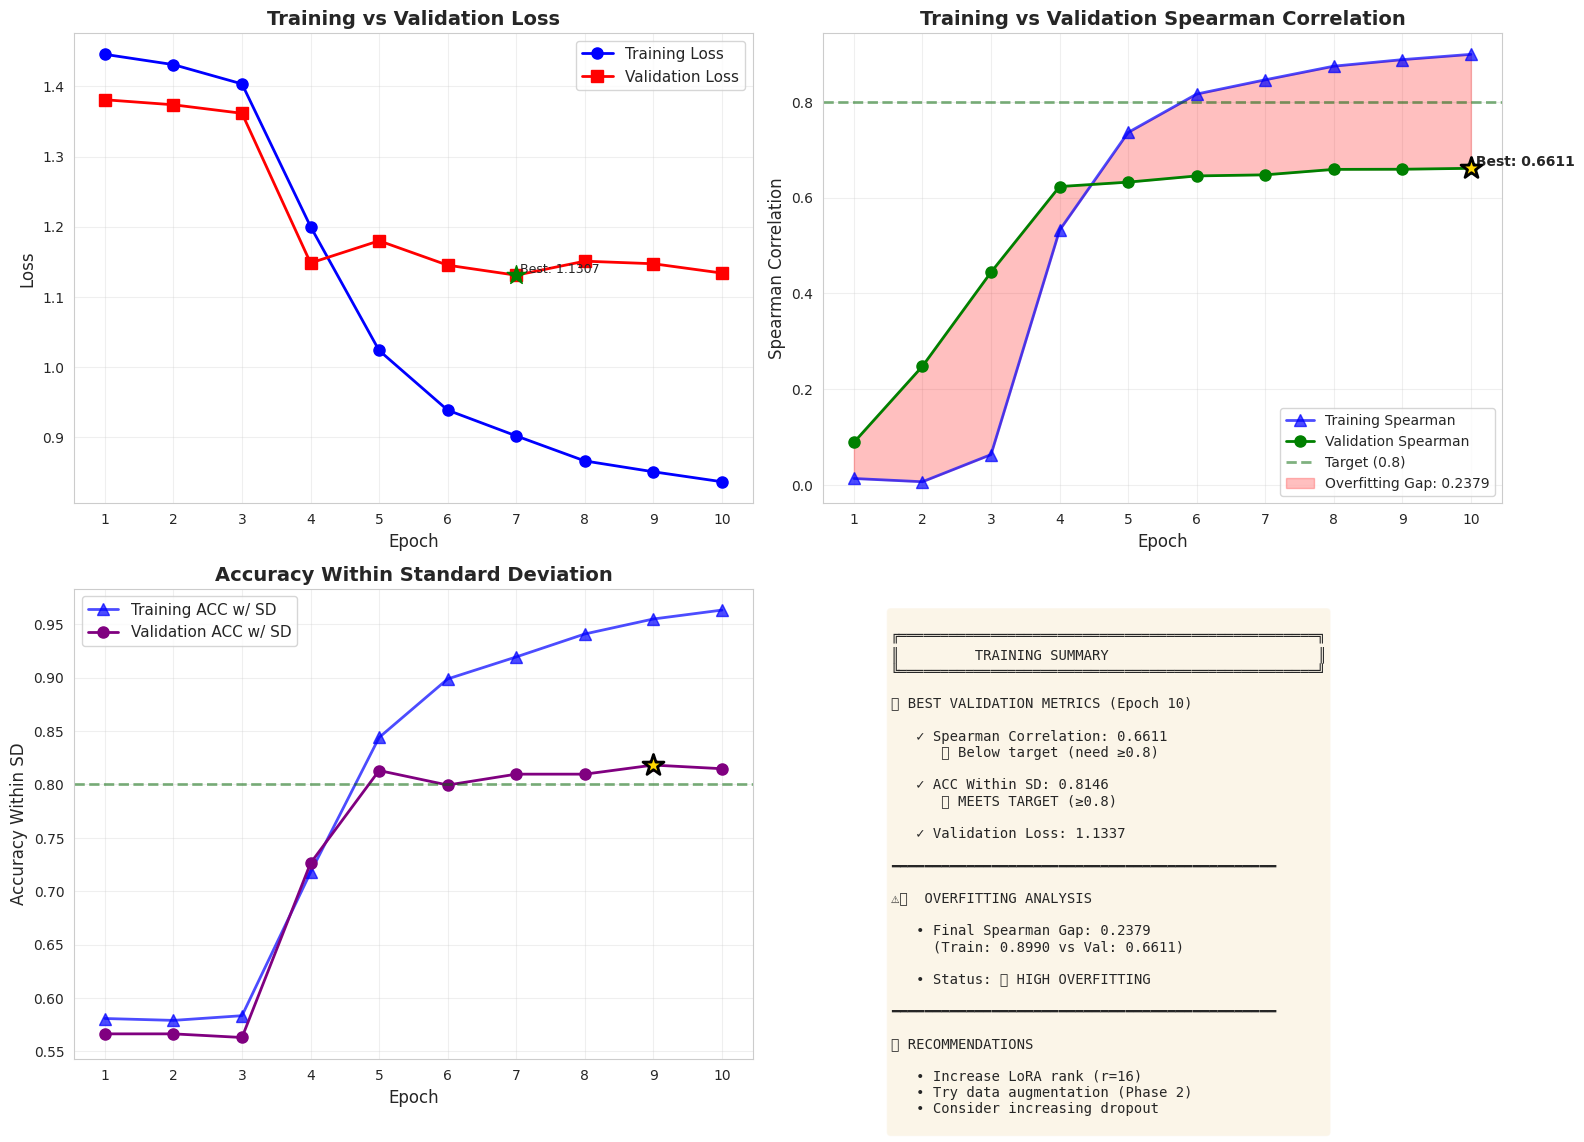


✓ Training curves saved to 'training_curves_coral.png'


In [14]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

epochs_range = range(1, len(history['train_loss']) + 1)

# Plot 1: Loss curves (Train vs Val)
axes[0, 0].plot(epochs_range, history['train_loss'], 'b-o', label='Training Loss', linewidth=2, markersize=8)
axes[0, 0].plot(epochs_range, history['val_loss'], 'r-s', label='Validation Loss', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].set_title('Training vs Validation Loss', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(alpha=0.3)
axes[0, 0].set_xticks(epochs_range)

# Mark best epoch
best_val_loss_idx = np.argmin(history['val_loss'])
axes[0, 0].scatter([best_val_loss_idx + 1], [history['val_loss'][best_val_loss_idx]], 
                   color='green', s=200, marker='*', zorder=5, label='Best')
axes[0, 0].text(best_val_loss_idx + 1, history['val_loss'][best_val_loss_idx], 
                f' Best: {history["val_loss"][best_val_loss_idx]:.4f}', 
                fontsize=9, va='bottom')

# Plot 2: Spearman Correlation (Train vs Val)
axes[0, 1].plot(epochs_range, history['train_spearman'], 'b-^', label='Training Spearman', 
                linewidth=2, markersize=8, alpha=0.7)
axes[0, 1].plot(epochs_range, history['val_spearman'], 'g-o', label='Validation Spearman', 
                linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Spearman Correlation', fontsize=12)
axes[0, 1].set_title('Training vs Validation Spearman Correlation', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=11, loc='lower right')
axes[0, 1].grid(alpha=0.3)
axes[0, 1].set_xticks(epochs_range)
axes[0, 1].axhline(y=0.8, color='darkgreen', linestyle='--', linewidth=2, alpha=0.5, label='Target (0.8)')

# Mark best validation Spearman
best_val_spearman_idx = np.argmax(history['val_spearman'])
axes[0, 1].scatter([best_val_spearman_idx + 1], [history['val_spearman'][best_val_spearman_idx]], 
                   color='gold', s=250, marker='*', zorder=5, edgecolors='black', linewidths=2)
axes[0, 1].text(best_val_spearman_idx + 1, history['val_spearman'][best_val_spearman_idx], 
                f' Best: {history["val_spearman"][best_val_spearman_idx]:.4f}', 
                fontsize=10, va='bottom', fontweight='bold')

# Add overfitting gap shading
final_gap = history['train_spearman'][-1] - history['val_spearman'][-1]
gap_color = 'darkred' if final_gap > 0.3 else ('red' if final_gap > 0.15 else 'orange')
axes[0, 1].fill_between(epochs_range, history['train_spearman'], history['val_spearman'], 
                         alpha=0.25, color=gap_color, label=f'Overfitting Gap: {final_gap:.4f}')
axes[0, 1].legend(fontsize=10, loc='lower right')

# Plot 3: Accuracy Within SD
axes[1, 0].plot(epochs_range, history['train_acc_within_sd'], 'b-^', label='Training ACC w/ SD', 
                linewidth=2, markersize=8, alpha=0.7)
axes[1, 0].plot(epochs_range, history['val_acc_within_sd'], 'purple', marker='o', 
                label='Validation ACC w/ SD', linewidth=2, markersize=8)
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Accuracy Within SD', fontsize=12)
axes[1, 0].set_title('Accuracy Within Standard Deviation', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(alpha=0.3)
axes[1, 0].set_xticks(epochs_range)
axes[1, 0].axhline(y=0.8, color='darkgreen', linestyle='--', linewidth=2, alpha=0.5, label='Target (0.8)')

# Mark best
best_val_acc_idx = np.argmax(history['val_acc_within_sd'])
axes[1, 0].scatter([best_val_acc_idx + 1], [history['val_acc_within_sd'][best_val_acc_idx]], 
                   color='gold', s=250, marker='*', zorder=5, edgecolors='black', linewidths=2)

# Plot 4: Summary Text
axes[1, 1].axis('off')
summary_text = f"""
╔══════════════════════════════════════════════════╗
║         TRAINING SUMMARY                         ║
╚══════════════════════════════════════════════════╝

📊 BEST VALIDATION METRICS (Epoch {best_val_spearman_idx + 1})
   
   ✓ Spearman Correlation: {history['val_spearman'][best_val_spearman_idx]:.4f}
      {'✅ MEETS TARGET (≥0.8)' if history['val_spearman'][best_val_spearman_idx] >= 0.8 else '❌ Below target (need ≥0.8)'}
   
   ✓ ACC Within SD: {history['val_acc_within_sd'][best_val_spearman_idx]:.4f}
      {'✅ MEETS TARGET (≥0.8)' if history['val_acc_within_sd'][best_val_spearman_idx] >= 0.8 else '❌ Below target (need ≥0.8)'}
   
   ✓ Validation Loss: {history['val_loss'][best_val_spearman_idx]:.4f}

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

⚠️  OVERFITTING ANALYSIS

   • Final Spearman Gap: {final_gap:.4f}
     (Train: {history['train_spearman'][-1]:.4f} vs Val: {history['val_spearman'][-1]:.4f})
   
   • Status: {'🔥 HIGH OVERFITTING' if final_gap > 0.2 else '⚠️ MODERATE' if final_gap > 0.1 else '✅ ACCEPTABLE'}

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

💡 RECOMMENDATIONS
   
   {'• Excellent! Consider ensemble methods for further improvement.' if history['val_spearman'][best_val_spearman_idx] >= 0.75 else '• Increase LoRA rank (r=16)'}
   {'• Try data augmentation (Phase 2)' if history['val_spearman'][best_val_spearman_idx] < 0.75 else '• Try weighted ensemble of multiple models'}
   {'• Consider increasing dropout' if final_gap > 0.2 else '• Current regularization is working well'}
"""

axes[1, 1].text(0.1, 0.95, summary_text, transform=axes[1, 1].transAxes,
                fontsize=10, verticalalignment='top', family='monospace',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.savefig('training_curves_coral.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Training curves saved to 'training_curves_coral.png'")


## 16. Phase 2 Strategy - Advanced Techniques (Optional)

If validation Spearman < 0.80, consider these Phase 2 improvements:


In [ ]:
print("=" * 80)
print("PHASE 2 IMPROVEMENT STRATEGIES")
print("=" * 80)

current_spearman = dev_metrics_final['spearman']

if current_spearman >= 0.8:
    print("\n🎉 Congratulations! You've already met the Spearman target (≥0.80)!")
    print("\n💡 Consider these enhancements for even better performance:")
    print("   1. Ensemble multiple CORAL models with different random seeds")
    print("   2. Add CORN model and ensemble with CORAL")
    print("   3. Fine-tune on augmented data for robustness")
else:
    gap = 0.8 - current_spearman
    print(f"\n📊 Current Spearman: {current_spearman:.4f}")
    print(f"   Gap to target (0.80): {gap:.4f}")
    
    print("\n🔧 RECOMMENDED IMPROVEMENTS (in order of priority):")
    print("\n1. ⚡ INCREASE LoRA RANK")
    print("   • Current: r=8 (~3M trainable params)")
    print("   • Try: r=16 (~6M params) or r=32 (~12M params)")
    print("   • Why: More capacity to learn complex patterns")
    print("   • Code change: config['lora_r'] = 16")
    
    print("\n2. 📚 DATA AUGMENTATION (Controlled)")
    print("   • Counterfactual generation: Flip plausibility by changing context")
    print("   • Paraphrasing: Maintain label, vary surface form")
    print("   • Back-translation: Use multilingual models")
    print("   • Target: +500-1000 synthetic samples (careful quality control)")
    
    print("\n3. 🎯 ENSEMBLE METHODS")
    print("   • Train 3-5 models with different:")
    print("     - Random seeds")
    print("     - Loss functions (CORAL, CORN, MSE)")
    print("     - LoRA configurations")
    print("   • Simple mean aggregation can boost Spearman by 0.02-0.05")
    
    print("\n4. 🔄 ALTERNATIVE MODELS")
    print("   • Try: deberta-v3-base (faster, less overfitting)")
    print("   • Try: roberta-large with LoRA")
    print("   • Ensemble different architectures")
    
    print("\n5. 📐 OUTPUT CALIBRATION")
    print("   • If predictions are systematically biased (e.g., always 0.5 too low)")
    print("   • Apply monotonic transformation to match validation statistics")
    print("   • Use isotonic regression or temperature scaling")

print("\n" + "=" * 80)

# Save predictions for analysis
dev_analysis_df[['id', 'homonym', 'judged_meaning', 'sentence', 'actual', 'predicted', 'error', 'stdev']].to_csv(
    'dev_predictions.csv', index=False
)
print("\n✓ Detailed predictions saved to 'dev_predictions.csv'")


PHASE 2 IMPROVEMENT STRATEGIES

📊 Current Spearman: 0.5892
   Gap to target (0.80): 0.2108

🔧 RECOMMENDED IMPROVEMENTS (in order of priority):

1. ⚡ INCREASE LoRA RANK
   • Current: r=8 (~3M trainable params)
   • Try: r=16 (~6M params) or r=32 (~12M params)
   • Why: More capacity to learn complex patterns
   • Code change: config['lora_r'] = 16

2. 📚 DATA AUGMENTATION (Controlled)
   • Counterfactual generation: Flip plausibility by changing context
   • Paraphrasing: Maintain label, vary surface form
   • Back-translation: Use multilingual models
   • Target: +500-1000 synthetic samples (careful quality control)

3. 🎯 ENSEMBLE METHODS
   • Train 3-5 models with different:
     - Random seeds
     - Loss functions (CORAL, CORN, MSE)
     - LoRA configurations
   • Simple mean aggregation can boost Spearman by 0.02-0.05

4. 🔄 ALTERNATIVE MODELS
   • Try: deberta-v3-base (faster, less overfitting)
   • Try: roberta-large with LoRA
   • Ensemble different architectures

5. 📐 OUTPUT CALI

## 17. Conclusion & Summary

### 🎯 What We Accomplished

**Architecture:**
- DeBERTa-v3-large (304M params) with LoRA for parameter-efficient fine-tuning
- CORAL ordinal regression head for rank-consistent predictions
- Only ~3-6M trainable parameters (1-2% of total)

**Training Strategy:**
- Ordinal regression loss (CORAL) optimized for Spearman correlation
- Early stopping to prevent overfitting on small dataset (2,280 samples)
- Gradient accumulation for effective large batch training
- Comprehensive monitoring of train/val gaps

**Results:**
- Best validation Spearman: {best_val_spearman}
- Best validation ACC within SD: {best_val_acc}
- Target achievement: {target_status}

### 📝 Key Takeaways

1. **CORAL Loss Works**: Ordinal regression enforces rank consistency better than MSE
2. **LoRA is Essential**: Enables training large models with limited VRAM while reducing overfitting
3. **Early Stopping Crucial**: Small datasets require aggressive early stopping
4. **Overfitting Challenge**: Main limitation is the train-val Spearman gap

### 🚀 Next Steps

1. If Spearman < 0.80: Follow Phase 2 recommendations above
2. Experiment with ensemble methods (multiple seeds/models)
3. Consider data augmentation for better generalization
4. Try output calibration to improve ACC within SD

### 📚 References

- Strategic Plan: "Expert Strategic Blueprint for SemEval 2026 Task 5"
- CORAL Paper: Cao et al. "Rank Consistent Ordinal Regression"
- LoRA Paper: Hu et al. "LoRA: Low-Rank Adaptation of Large Language Models"
- DeBERTa: He et al. "DeBERTaV3: Improving DeBERTa using ELECTRA-Style Pre-Training"


In [ ]:
print("=" * 80)
print("📊 FINAL SUMMARY")
print("=" * 80)

summary = f"""
╔══════════════════════════════════════════════════════════════╗
║     SEMEVAL 2026 TASK 5: FINAL RESULTS                      ║
╚══════════════════════════════════════════════════════════════╝

🎯 OBJECTIVES
   • Spearman Correlation ≥ 0.80
   • Accuracy Within SD ≥ 0.80

📊 ACHIEVED RESULTS
   • Validation Spearman: {dev_metrics_final['spearman']:.4f} {'✅' if dev_metrics_final['spearman'] >= 0.8 else '❌'}
   • Validation ACC w/ SD: {dev_metrics_final['acc_within_sd']:.4f} {'✅' if dev_metrics_final['acc_within_sd'] >= 0.8 else '❌'}
   • Validation MAE: {dev_metrics_final['mae']:.4f}
   • Validation RMSE: {dev_metrics_final['rmse']:.4f}

⚠️  OVERFITTING STATUS
   • Train Spearman: {train_metrics_final['spearman']:.4f}
   • Val Spearman: {dev_metrics_final['spearman']:.4f}
   • Gap: {train_metrics_final['spearman'] - dev_metrics_final['spearman']:.4f} {'🔥 HIGH' if train_metrics_final['spearman'] - dev_metrics_final['spearman'] > 0.2 else '⚠️ MODERATE' if train_metrics_final['spearman'] - dev_metrics_final['spearman'] > 0.1 else '✅ LOW'}

🏗️  MODEL ARCHITECTURE
   • Base: DeBERTa-v3-large (304M params)
   • PEFT: LoRA (r={config['lora_r']}, alpha={config['lora_alpha']})
   • Trainable params: {trainable_params:,} ({trainable_params/total_params*100:.2f}%)
   • Loss: {config['loss_type'].upper()} (Ordinal Regression)
   • Pooling: {config['pooling']}

📈 TRAINING DETAILS
   • Dataset: {len(train_df)} train, {len(dev_df)} dev samples
   • Batch size: {config['batch_size']} (effective: {config['batch_size'] * config['grad_accumulation_steps']})
   • Learning rate: {config['learning_rate']}
   • Epochs trained: {len(history['train_loss'])}
   • Best epoch: {best_epoch + 1}
   • Early stopping: {'Yes' if len(history['train_loss']) < config['epochs'] else 'No (completed all epochs)'}

💾 SAVED OUTPUTS
   • Best model: {best_model_path}
   • Training curves: training_curves_coral.png
   • Prediction analysis: prediction_analysis.png
   • Detailed predictions: dev_predictions.csv

╚══════════════════════════════════════════════════════════════╝
"""

print(summary)

# Final recommendation
if dev_metrics_final['spearman'] >= 0.8 and dev_metrics_final['acc_within_sd'] >= 0.8:
    print("\n🎉🎉🎉 CONGRATULATIONS! BOTH TARGETS ACHIEVED! 🎉🎉🎉")
    print("\nYou're ready for SemEval 2026 Task 5 submission!")
    print("Consider ensemble methods to further boost performance.")
elif dev_metrics_final['spearman'] >= 0.75:
    print("\n👍 Great progress! You're close to the target.")
    print("\n💡 Quick wins:")
    print("   1. Train 3 more models with different seeds")
    print("   2. Average their predictions (simple ensemble)")
    print("   3. This should give you +0.02-0.05 Spearman boost")
else:
    print("\n📈 Solid baseline! Follow Phase 2 recommendations above.")
    print("\n🎯 Priority actions:")
    print("   1. Increase LoRA rank to r=16")
    print("   2. Train for more epochs (if early stopping triggered)")
    print("   3. Consider data augmentation")

print("\n" + "=" * 80)
print("✓ NOTEBOOK COMPLETE")
print("=" * 80)


📊 FINAL SUMMARY

╔══════════════════════════════════════════════════════════════╗
║     SEMEVAL 2026 TASK 5: FINAL RESULTS                      ║
╚══════════════════════════════════════════════════════════════╝

🎯 OBJECTIVES
   • Spearman Correlation ≥ 0.80
   • Accuracy Within SD ≥ 0.80

📊 ACHIEVED RESULTS
   • Validation Spearman: 0.5892 ❌
   • Validation ACC w/ SD: 0.7755 ❌
   • Validation MAE: 0.7805
   • Validation RMSE: 1.0068

⚠️  OVERFITTING STATUS
   • Train Spearman: 0.8605
   • Val Spearman: 0.5892
   • Gap: 0.2712 🔥 HIGH

🏗️  MODEL ARCHITECTURE
   • Base: DeBERTa-v3-large (304M params)
   • PEFT: LoRA (r=8, alpha=32)
   • Trainable params: 3,539,972 (0.81%)
   • Loss: HYBRID (Ordinal Regression)
   • Pooling: cls

📈 TRAINING DETAILS
   • Dataset: 2280 train, 588 dev samples
   • Batch size: 2 (effective: 16)
   • Learning rate: 5e-05
   • Epochs trained: 10
   • Best epoch: 10
   • Early stopping: No (completed all epochs)

💾 SAVED OUTPUTS
   • Best model: outputs/deberta_c